In [1]:
import json
import yfinance as yf
import numpy as np
import pandas as pd
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

In [2]:
start = pd.to_datetime('2007-07-07')

In [3]:
stock = ['AMZN']

In [4]:
data = yf.download(stock, start=start, end=datetime.date.today())

[*********************100%***********************]  1 of 1 completed


In [5]:
min_max = preprocessing.MinMaxScaler()

In [6]:
data_scaled = pd.DataFrame(min_max.fit_transform(data), columns=data.columns)

In [7]:
data_scaled_close = data_scaled['Close']

In [8]:
np.array(data_scaled_close).reshape(-1, 1).shape

(3883, 1)

In [9]:
train_num = int(data_scaled.shape[0] * 0.7)

In [10]:
test = pd.Timestamp("2018-07-31 00:00:00", tz="America/New_York")

In [11]:
data['Close'][data.index > test]

Date
2018-08-01 00:00:00-04:00    89.858498
2018-08-02 00:00:00-04:00    91.716499
2018-08-03 00:00:00-04:00    91.164497
2018-08-06 00:00:00-04:00    92.387497
2018-08-07 00:00:00-04:00    93.124001
                               ...    
2022-11-30 00:00:00-05:00    96.540001
2022-12-01 00:00:00-05:00    95.500000
2022-12-02 00:00:00-05:00    94.129997
2022-12-05 00:00:00-05:00    91.010002
2022-12-06 00:00:00-05:00    88.250000
Name: Close, Length: 1096, dtype: float64

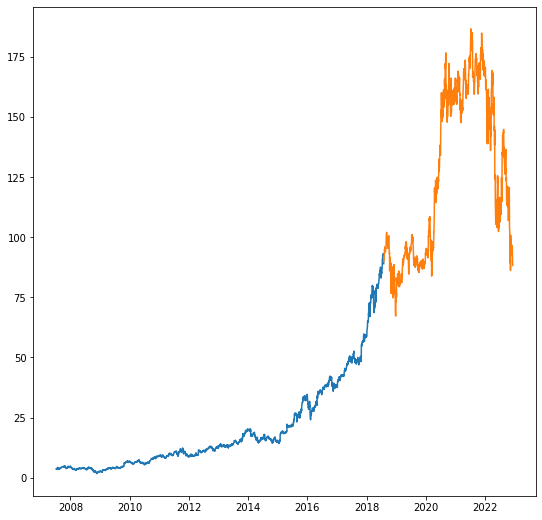

In [12]:
plt.figure(figsize=(9, 9))

plt.plot(data['Close'][data.index < test])
plt.plot(data['Close'][data.index > test])
plt.show()9

In [13]:
data_train = np.array(data_scaled['Close'][data.index < test]).reshape(-1, 1)
data_test = np.array(data_scaled['Close'][data.index > test]).reshape(-1, 1)
#data_train = data_scaled['Close'][data.index < test]
#data_test = data_scaled['Close'][data.index > test]

In [14]:
data_train.shape[0]

2786

In [15]:
len(data_train)

2786

In [16]:
data_test.shape

(1096, 1)

In [17]:
def get_train(train_scaled, time_steps = 3):
    x_train = []
    y_train = []
    for i in range(time_steps, train_scaled.shape[0]):
        x_train.append(train_scaled[i - time_steps:i, 0])
        y_train.append(train_scaled[i, 0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    return x_train, y_train

In [18]:
x_train, y_train = get_train(data_train)

In [19]:
print("x.shape = ", x_train.shape, ", y.shape = ", y_train.shape)

x.shape =  (2783, 3, 1) , y.shape =  (2783,)


In [20]:
def get_test(test_scaled, time_steps = 3):
    x_test = []
    y_test = []
    for i in range(time_steps, test_scaled.shape[0]):
        x_test.append(test_scaled[i - time_steps:i])
        y_test.append(test_scaled[i, 0])
        
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return x_test, y_test

In [21]:
x_test, y_test = get_test(data_test)

In [22]:
print("xt.shape = ", x_test.shape, ", yt.shape = ", y_test.shape)

xt.shape =  (1093, 3, 1) , yt.shape =  (1093,)


In [23]:
def long_short_term_memory_model(alpha=0.2):
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(32, 5, activation='relu', strides=1, padding='causal', input_shape=[3, 1]))
    model.add(layers.Dropout(alpha))
    
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.Dropout(alpha))
    
    model.add(layers.LSTM(64))
    model.add(layers.Dense(1))

    return model

In [30]:
model = long_short_term_memory_model(alpha=0.2)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 3, 32)             192       
                                                                 
 dropout_2 (Dropout)         (None, 3, 32)             0         
                                                                 
 lstm_2 (LSTM)               (None, 3, 64)             24832     
                                                                 
 dropout_3 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 58,113
Trainable params: 58,113
Non-trai

In [31]:
defined_metrics = tf.keras.metrics.MeanSquaredError() # хз
defined_loss = tf.keras.losses.MeanSquaredError() # хз
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.0005) 

model.compile(optimizer=opt_adam, loss=defined_loss, metrics=defined_metrics)

In [32]:
history = model.fit(x_train, y_train, epochs=40, batch_size=1024, validation_data=(x_test, y_test))

Epoch 1/40
3/3 [==============================] - 4s 522ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.4550 - val_mean_squared_error: 0.4550
Epoch 2/40
3/3 [==============================] - 0s 70ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.4216 - val_mean_squared_error: 0.4216
Epoch 3/40
3/3 [==============================] - 0s 56ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.3870 - val_mean_squared_error: 0.3870
Epoch 4/40
3/3 [==============================] - 0s 62ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.3508 - val_mean_squared_error: 0.3508
Epoch 5/40
3/3 [==============================] - 0s 59ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.3135 - val_mean_squared_error: 0.3135
Epoch 6/40
3/3 [==============================] - 0s 58ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.2761 - val_mean_squared_error: 0.2761
Epoch 7/40
3/3 [=============================

In [27]:
output = model.predict(x_test)

35/35 [==============================] - 1s 6ms/step


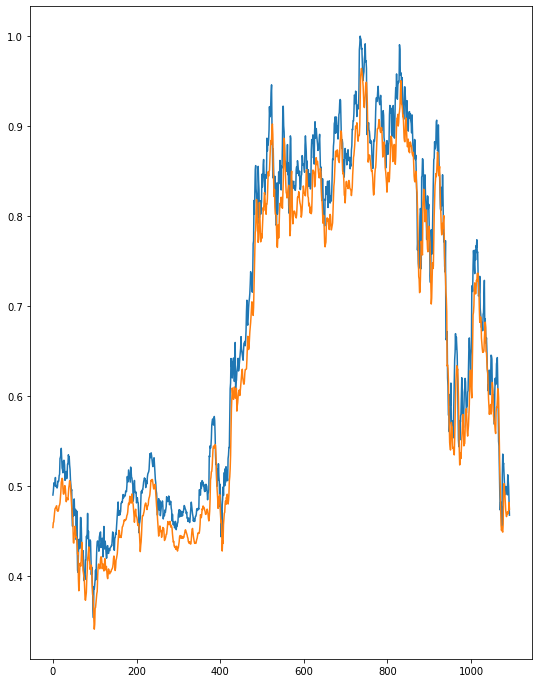

In [33]:
plt.figure(figsize=(9, 12))

plt.plot(y_test)
plt.plot(output)
plt.show()